In [1]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [2]:
import sys, os
sys.path.append('../')

import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)


import gpflow

import gpflux
from gpflux import DeepGP
from gpflux.layers import GPLayer, LatentVariableConcatLayer, LinearLayer
from gpflux.models.encoders import DirectlyParameterized
import numpy as np

import matplotlib.pyplot as plt

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("vol/bitbucket/hrs13/data/MNIST_data/", one_hot=True)
X = mnist.train.labels.astype(float)
Y = mnist.train.images.astype(float)
Y -= np.average(Y, 0)


Extracting vol/bitbucket/hrs13/data/MNIST_data/train-images-idx3-ubyte.gz
Extracting vol/bitbucket/hrs13/data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting vol/bitbucket/hrs13/data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting vol/bitbucket/hrs13/data/MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
N = 5000
u, d, P = np.linalg.svd(Y[:N, :], full_matrices=False)
W_pca = u * d[None, :]
W_pca -= np.average(W_pca, 0)
W_pca /= np.std(W_pca, 0)


In [5]:
# These are some things we'll need several times, so make them functions for convenience 

kern = lambda q: gpflow.kernels.RBF(q, variance=2., lengthscales=float(2)**0.5 * np.ones(q), ARD=True)

inducing_pts = lambda m, q: gpflow.features.InducingPoints(np.random.randn(m, q))

def lik():
    l = gpflow.likelihoods.Gaussian()
    l.variance = 0.05
    return l

def train(model, iterations, gamma, adam_lr, sess):
    var_list = [[model.layers[-1].q_mu, model.layers[-1].q_sqrt]] 
    model.layers[-1].q_mu.set_trainable(False)
    model.layers[-1].q_sqrt.set_trainable(False)

    op1 = gpflow.training.NatGradOptimizer(gamma=gamma).make_optimize_tensor(model, var_list=var_list)
    op2 = gpflow.training.AdamOptimizer(adam_lr).make_optimize_tensor(model)
    op3 = model.likelihood_tensor
    
    tilesess = model.enquire_session()

    L = []
    for it in range(iterations):
        sess.run(op1)
        sess.run(op2)
        L.append(sess.run(op3))
    model.anchor(sess)
    
    plt.plot(L[2:])
    plt.show()

def plot_outputs(model, x, sess, S=9, l=2., single_plot=True):
    xx, yy = np.linspace(-l, l, S), np.linspace(-l, l, S)
    XX, YY = np.meshgrid(xx, yy)
    Ws = np.array([XX.flatten(), YY.flatten()]).T
    
    ms, vs = model.predict_f_with_Ws(np.repeat(x, S**2, axis=0),  # x is shape N, D
                                     np.repeat(Ws, len(x), axis=0), # Ws is shape S**2, 2
                                     session=sess)
    mss = np.split(ms, len(x))
    if single_plot:
        s = 5
        fig, axs = plt.subplots(1, len(x), figsize=(s * len(x), s))
        if len(x) == 1:
            axs = axs,
        for ax, ms in zip(axs, mss):
            ms = ms.reshape(S**2, 28, 28)
            ms = np.split(ms, S, axis=0)  # S * [S, 28, 28]
            ms = np.concatenate(ms, 2)  # [S, 28, 28S]
            ms = np.split(ms, S, axis=0)  # S * [1, 28, 28S]
            ms = np.concatenate(ms, 1)
            ms = np.reshape(ms, (S*28, S*28))
            ax.matshow(ms)
#             fig.colorbar(, ax=ax)
            ax.set_xticks([])
            ax.set_yticks([])
    
    else:
        for ms in mss:
            fig, axs = plt.subplots(S, S, figsize=(10, 10))
            for m, ax, W in zip(ms, axs.ravel(), Ws):
                fig.colorbar(ax.matshow(m.reshape(28, 28)), ax=ax)
                ax.set_title('{} {}'.format(*W))
                ax.set_xticks([])
                ax.set_yticks([])
    plt.show()

    
def plot_latents(model, X, Y, sess, c=None):
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    Ws = []
    Zs = []
    for l in range(len(model.layers)):
        if isinstance(model.layers[l], LatentVariableConcatLayer):
            model.layers[l].encode_once()
            W = sess.run(model.layers[l].q_mu, {model.X._dataholder_tensor:X,
                                                model.Y._dataholder_tensor:Y})
            Z = model.layers[l+1].feature.Z.read_value(session=sess)
            Ws.append(W)
            Zs.append(Z[:, -W.shape[1]:])
    Ws = np.concatenate(Ws, 1)
    Zs = np.concatenate(Zs, 1)
    
    if c is None:
        c = np.argmax(X, 1)
    ax.scatter(Ws[:, 0], Ws[:, 1], marker='.', c=c)
    ax.scatter(Zs[:, 0], Zs[:, 1], marker='x', c='k')
    plt.show()



# GP-LVM

The most vanilla GP-LVM with no minibatches and no recognition network
The model is 
$$W \to f(W) \to Y$$
$$W\sim \mathcal N (0, 1), \quad f\sim\mathcal{GP}$$

but we implemented it as a supervised model with
$$ 0 \to [0, W] \to f([0, W]) -> Y$$

where 0 stands for an array of size (N, 0)

Here we initialize $q(W)$ to the PCA projection 

In [6]:
N = 500
M = 25
Q = 2
iterations = 2000

layers = [
    LatentVariableConcatLayer(Q, encoder=DirectlyParameterized(N, Q, mean=W_pca[:N, :Q])),
    GPLayer(kern(Q), inducing_pts(M, Q), 784),
]

model_gplvm = gpflux.DeepGP(np.zeros((N, 0)), Y[:N, :], layers, likelihood=lik())

sess = model_gplvm.enquire_session()

# train(model_gplvm, iterations, 1., 0.005, sess)
# plot_latents(model_gplvm, np.zeros((N, 0)), Y[:N, :], sess, c=np.argmax(X[:N, :], 1))
# plot_outputs(model_gplvm, np.zeros((1, 0)), sess)

# GP-LVM amortized

As above, but with a recognition network. The network is initialized randomly, so we have to just hope that the inducing points are in the right place. Alternatively, we could pre-train the recognition network. 

In [7]:
# batch_size = 500

# layers = [
#     LatentVariableConcatLayer(Q, XY_dim=784),
#     GPLayer(kern(Q), inducing_pts(M, Q), 784)
# ]

# model_gplvm_amortized = gpflux.DeepGP(np.zeros((len(Y), 0)), Y, layers, 
#                                       likelihood=lik(), batch_size=batch_size)

# train(model_gplvm_amortized, iterations, 0.01, 0.005, sess)
# plot_latents(model_gplvm_amortized, np.zeros((N, 0)), Y[:N, :], sess, c=np.argmax(X[:N, :], 1))
# plot_outputs(model_gplvm_amortized, np.zeros((1, 0)), sess)

# GP-CDE

$$X \to [X, W] \to f([X, W]) \to Y$$
$$W\sim \mathcal N(0, 1),\quad f\sim\mathcal{GP}$$

The shapes in this examples are

* 10 (input)
* 10 + 2 (input + latent variables)
* 784 (GPs)



In [8]:
# layers = [
#     LatentVariableConcatLayer(Q, XY_dim=794),
#     GPLayer(kern(Q + 10), inducing_pts(M, Q + 10), 784)
# ]

# model_gpcde = gpflux.DeepGP(X, Y, layers, batch_size=batch_size, likelihood=lik())

# train(model_gpcde, iterations, 0.01, 0.005, sess)

# plot_latents(model_gpcde, X[:300, :], Y[:300, :], sess)

# plot_outputs(model_gpcde, np.eye(10)[0:5, :], sess)
# plot_outputs(model_gpcde, np.eye(10)[5:10, :], sess)

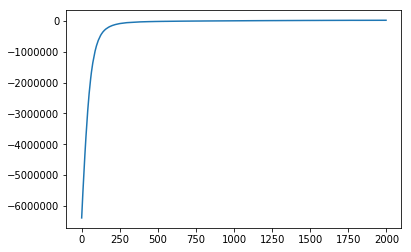

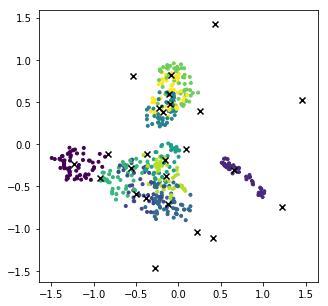

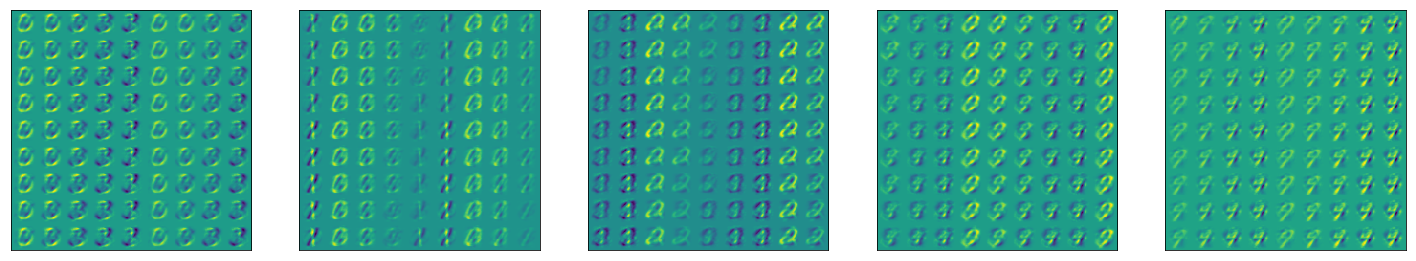

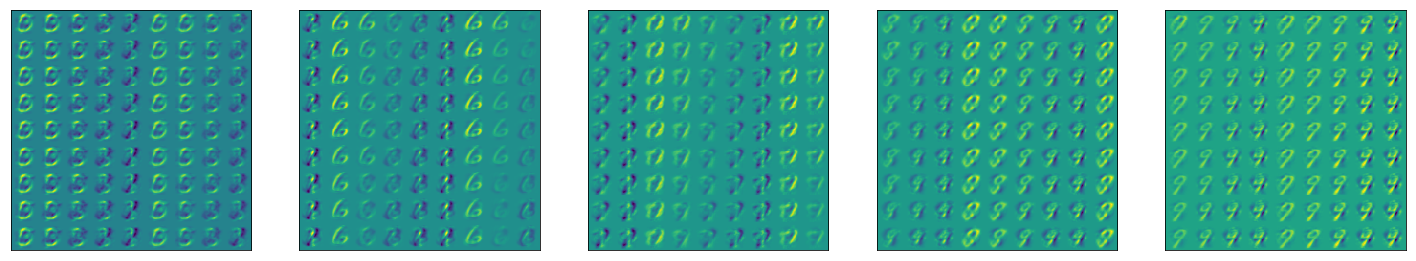

In [10]:
layers = [
    LatentVariableConcatLayer(Q, encoder=DirectlyParameterized(N, Q, mean=W_pca[:N, :Q])),
    GPLayer(kern(Q + 10), inducing_pts(M, Q + 10), 784)
]

model_gpcde_no_enc = gpflux.DeepGP(X[:N], Y[:N], layers, likelihood=lik())

model_gpcde_no_enc.
train(model_gpcde_no_enc, iterations, 0.01, 0.005, sess)

plot_latents(model_gpcde_no_enc, X[:N, :], Y[:N, :], sess, c=np.argmax(X[:N], 1))

plot_outputs(model_gpcde_no_enc, np.eye(10)[0:5, :], sess)
plot_outputs(model_gpcde_no_enc, np.eye(10)[5:10, :], sess)

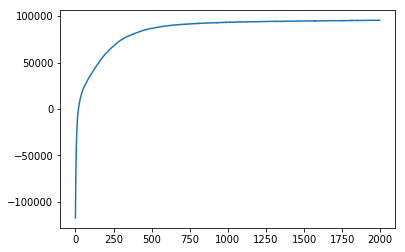

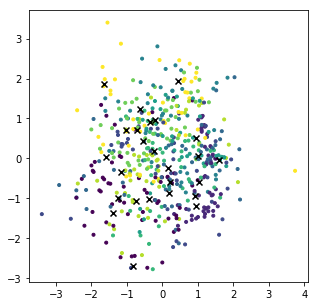

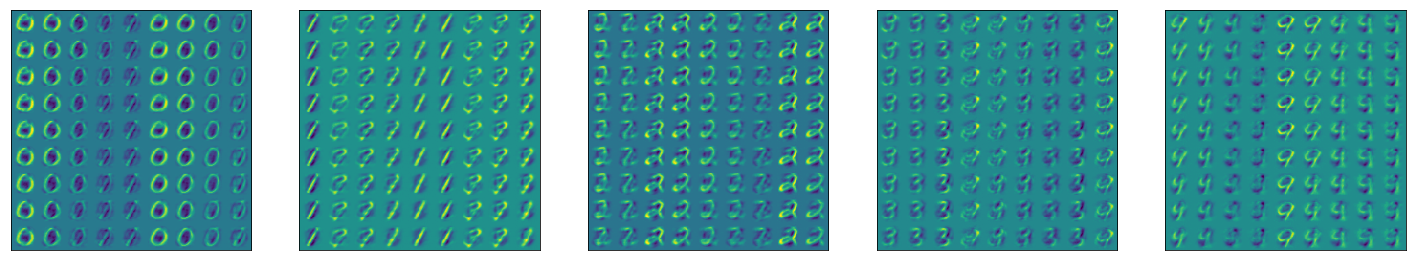

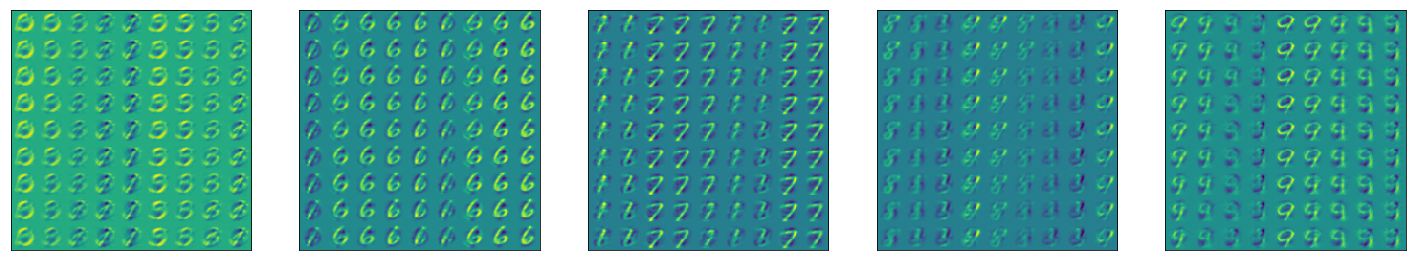

In [11]:
layers = [
    LatentVariableConcatLayer(Q, encoder=DirectlyParameterized(N, Q, mean=W_pca[:N, :Q])),
    GPLayer(kern(Q + 10), inducing_pts(M, Q + 10), 20)
]

model_gpcde_no_enc_P = gpflux.DeepGP(X[:N], Y[:N], layers, likelihood=lik(), P=P[:20, :].copy())

train(model_gpcde_no_enc_P, iterations, 0.01, 0.005, sess)

plot_latents(model_gpcde_no_enc_P, X[:N, :], Y[:N, :], sess, c=np.argmax(X[:N], 1))

plot_outputs(model_gpcde_no_enc_P, np.eye(10)[0:5, :], sess)
plot_outputs(model_gpcde_no_enc_P, np.eye(10)[5:10, :], sess)

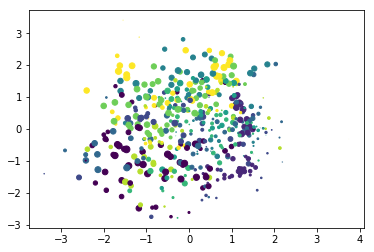

[1.81160867 2.56297718 1.80967908 1.94276618 2.4717423  1.63288577
 1.83079902 2.03980199 2.34942901 2.56995009 1.58255697 1.37111501]


In [38]:
a = model_gpcde_no_enc_P.layers[0].encoder.std.read_value()
b = model_gpcde_no_enc_P.layers[0].encoder.mean.read_value()

plt.scatter(b[:, 0], b[:, 1], s=0.0001/a[:, 1], c=np.argmax(X[:N], 1))
plt.show()
print(model_gpcde_no_enc_P.layers[1].kern.lengthscales.read_value())

model_gpcde_no_enc_P.layers[0].encode_once()
W = sess.run(model_gpcde_no_enc_P.layers[0].q_mu, {model_gpcde_no_enc_P.X._dataholder_tensor:X[:N],
                                    model_gpcde_no_enc_P.Y._dataholder_tensor:Y[:N]})


In [45]:
Z = model_gpcde_no_enc_P.layers[1].feature.Z.read_value()
WZ = np.concatenate([Z, W], 0)

ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [46]:
print(Z.shape)
print(W.shape)

(25, 12)
(500, 2)


# GP-CDE with linear projection on outputs

$$X \to [X, W] \to f([X, W]) \to f([X, W]) P \to Y$$
$$W\sim \mathcal N(0, 1),\quad f\sim\mathcal{GP}$$

The shapes in this examples are

* 10 (input)
* 10 + 2 (input + latent variables)
* 20 (GPs)
* 784 (linear projection)


In [ ]:
num_gps = 20

layers = [
    LatentVariableConcatLayer(Q, XY_dim=794),
    GPLayer(kern(Q + 10), inducing_pts(M, Q + 10), num_gps),
    ]

model_gpcde_linear = gpflux.DeepGP(X, Y, layers, 
                                   batch_size=batch_size, 
                                   likelihood=lik(), 
                                   P=P[:num_gps, :].copy())

train(model_gpcde_linear, iterations, 0.01, 0.005, sess)

plot_latents(model_gpcde_linear, X[:500, :], Y[:500, :], sess)

plot_outputs(model_gpcde_linear, np.eye(10)[0:5, :], sess)
plot_outputs(model_gpcde_linear, np.eye(10)[5:10, :], sess)


# Conditional deep model with latent at start

$$X \to [X, W] \to f_1([X, W]) \to f_2(f_2([X, W])) \to f_2(f_2([X, W])) P \to Y$$
$$W\sim \mathcal N(0, 1),\quad f_1, f_2\sim\mathcal{GP}$$

The shapes in this examples are

* 10 (input)
* 10 + 2 (input + latent variables)
* 13 (GPs with mean function)
* 20 (GPs)
* 784 (linear projection)



In [ ]:
gp1_dim = 13
gp2_dim = 20

A = np.concatenate([np.eye(Q + 10), np.zeros((Q + 10, gp1_dim - Q - 10))], 1)

layers = [
    LatentVariableConcatLayer(Q, XY_dim=794),
    GPLayer(kern(Q + 10), inducing_pts(M, Q + 10), gp1_dim, 
            mean_function=gpflow.mean_functions.Linear(A=A)),
    GPLayer(kern(gp1_dim), inducing_pts(M, gp1_dim), gp2_dim),
]

layers[1].kern.variance = 1e-3  # otherwise the GP might throw the inputs too far off

model_dgp_L_GP_GP = gpflux.DeepGP(X, Y, layers, 
                                  batch_size=batch_size, 
                                  P=P[:gp2_dim, :].copy())

train(model_dgp_L_GP_GP, iterations, 0.01, 0.001, sess)

plot_latents(model_dgp_L_GP_GP, X[:300, :], Y[:300, :], sess)

plot_outputs(model_dgp_L_GP_GP, np.eye(10)[0:5, :], sess)
plot_outputs(model_dgp_L_GP_GP, np.eye(10)[5:10, :], sess)

# Conditional deep model with latents at end 

$$X \to f_1(X) \to [f_1(X), W] \to f_2([f_1(X), W]) \to f_2([f_1(X), W]) P \to Y$$
$$W\sim \mathcal N(0, 1),\quad f_1, f_2\sim\mathcal{GP}$$

The shapes in this examples are

* 10 (input)
* 12 (GPs with mean function)
* 12 + 2 (concat latent variables)
* 20 (GPs)
* 784 (linear projection)



In [ ]:
gp1_dim = 12
gp2_dim = 20

A = np.concatenate([np.eye(10), np.zeros((10, gp1_dim - 10))], 1)

layers = [
    GPLayer(kern(10), inducing_pts(M, 10), gp1_dim, 
            mean_function=gpflow.mean_functions.Linear(A=A)), # 10 -> gp1_dim,
    LatentVariableConcatLayer(Q, XY_dim=794), # gp1_dim -> gp1_dim + Q
    GPLayer(kern(gp1_dim + Q), inducing_pts(M, gp1_dim + Q), gp2_dim),  # gp1_dim + Q -> gp2_dim
#     LinearLayer(gp2_dim, 784)
]

layers[0].kern.variance = 1e-3

model_dgp_GP_L_GP = gpflux.DeepGP(X, Y, layers, 
                                  batch_size=batch_size, 
                                  P=P[:gp2_dim, :].copy())

train(model_dgp_GP_L_GP, iterations, 0.01, 0.001, sess)

plot_latents(model_dgp_GP_L_GP, X[:300, :], Y[:300, :], sess)

plot_outputs(model_dgp_GP_L_GP, np.eye(10)[0:5, :], sess)
plot_outputs(model_dgp_GP_L_GP, np.eye(10)[5:10, :], sess)


# Conditional deep model with two layers of latents 

$$X \to [X, W_1] \to f_1([X, W_1]) \to [f_1([X, W_1]), W_2] \to f_2[f_1([X, W_1]), W_2] \to f_2[f_1([X, W_1]), W_2] P \to Y$$
$$W_1, W_2, \sim \mathcal N(0, 1),\quad f_1, f_2\sim\mathcal{GP}$$

The shapes in this examples are

* 10 (input)
* 10 + 1 (input concat latent variables)
* 12 (GPs with mean function)
* 12 + 1 (concat latent variables)
* 20 (GPs)
* 784 (linear projection)

In [ ]:
gp1_dim = 12
gp2_dim = 20

Q1 = 1
Q2 = 1

A = np.concatenate([np.eye(Q1 + 10), np.zeros((Q1 + 10, gp1_dim - Q1 - 10))], 1)

layers = [
    LatentVariableConcatLayer(Q1, XY_dim=794), # 10 -> 10 + Q1
    GPLayer(kern(10 + Q1), inducing_pts(M, 10 + Q1), gp1_dim, 
            mean_function=gpflow.mean_functions.Linear(A=A)), # 10 -> gp1_dim,
    LatentVariableConcatLayer(Q2, XY_dim=794), # gp1_dim -> gp1_dim + Q2
    GPLayer(kern(gp1_dim + Q2), inducing_pts(M, gp1_dim + Q2), gp2_dim),  # gp1_dim + Q2 -> gp2_dim
]

layers[1].kern.variance = 1e-3


model_dgp_L_GP_L_GP = gpflux.DeepGP(X, Y, layers, 
                                    batch_size=batch_size, 
                                    P=P[:gp2_dim, :].copy())

train(model_dgp_L_GP_L_GP, iterations, 0.01, 0.005, sess)

plot_latents(model_dgp_L_GP_L_GP, X[:300, :], Y[:300, :], sess)

plot_outputs(model_dgp_L_GP_L_GP, np.eye(10)[0:5, :], sess)
plot_outputs(model_dgp_L_GP_L_GP, np.eye(10)[5:10, :], sess)



# Unconditional deep model with two layers of latents 

$$ W_1 \to f_1(W_1) \to [f_1(W_1), W2] \to f_2[f_1(W_1), W2] \to f_2[f_1(W_1), W2] P \to Y$$
$$W_1, W_2, \sim \mathcal N(0, 1),\quad f_1, f_2\sim\mathcal{GP}$$

The shapes in this examples are

* 0 + 1 (latent variables)
* 3 (GPs with mean function)
* 3 + 1 (concat latent variables)
* 20 (GPs)
* 784 (linear projection)


In [ ]:
gp1_dim = 3
gp2_dim = 20

Q1 = 1
Q2 = 1

A = np.concatenate([np.eye(Q1), np.zeros((Q1, gp1_dim - Q1))], 1)

layers = [
    LatentVariableConcatLayer(Q1, XY_dim=784), # 10 -> 10 + Q1
    GPLayer(kern(Q1), inducing_pts(M, Q1), gp1_dim), # 10 -> gp1_dim,
    LatentVariableConcatLayer(Q2, XY_dim=784), # gp1_dim -> gp1_dim + Q2
    GPLayer(kern(gp1_dim + Q2), inducing_pts(M, gp1_dim + Q2), gp2_dim),  # gp1_dim + Q2 -> gp2_dim
]

layers[1].kern.variance = 1e-3

model_dgp_L_GP_L_GP_unconditional = gpflux.DeepGP(np.zeros((len(Y), 0)), Y, layers, 
                                                  batch_size=batch_size, 
                                                  P=P[:gp2_dim, :].copy())

train(model_dgp_L_GP_L_GP_unconditional, iterations, 0.01, 0.005, sess)

plot_latents(model_dgp_L_GP_L_GP_unconditional, np.zeros((300, 0)), Y[:300, :], sess, c=np.argmax(X[:300], 1))


plot_outputs(model_dgp_L_GP_L_GP_unconditional, np.zeros((1, 0)), sess)
